In [226]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import math
import json
import re
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
np.random.seed(42)
random.seed(42)

# Data

## Single

In [227]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 1234

# Python & NumPy
random.seed(SEED)
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Determinism flags
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [228]:
encoder_input = torch.randn(1, 512, device=device)
bottleneck_input = torch.randn(256, 32, device=device)
decoder_first_input = torch.randn(256, 32, device=device)
decoder_last_input = torch.randn(64, 256, device=device)
out_input = torch.randn(16, 512, device=device)

## Multiple

In [229]:
def create_inputs_decoder(seeds):
    """
    Iterates through a list of seeds, generates tensors, and exports them.
    """
    inputs = []
    for seed in seeds:
        print(f"Processing Seed: {seed}")
        
        # 1. Set Seeds for Reproducibility
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 3. Generate Tensors
        # Note: These are re-generated per seed to ensure different random values
        tensors_to_process = [
            ("decoder_last_input", torch.randn(64, 256, device=device), False), # x->y
        ]

        for name, tensor, y_first in tensors_to_process:
            item = {}
            item["type"] = name
            item["seed"] = seed
            item["data"] = tensor
            inputs.append(item)
        
    return inputs

def create_inputs_out(seeds):
    """
    Iterates through a list of seeds, generates tensors, and exports them.
    """
    inputs = []
    for seed in seeds:
        print(f"Processing Seed: {seed}")
        
        # 1. Set Seeds for Reproducibility
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 3. Generate Tensors
        # Note: These are re-generated per seed to ensure different random values
        tensors_to_process = [
            ("out_input", torch.randn(16, 512, device=device), False),
        ]

        for name, tensor, _ in tensors_to_process:
            item = {}
            item["type"] = name
            item["seed"] = seed
            item["data"] = tensor
            inputs.append(item)
        
    return inputs

In [230]:
seed_arr = [1234, 420, 67, 69, 13523100, 13223051, 13223075, 42, 21, 20]
inputs_decoder_array = create_inputs_decoder(seed_arr)
inputs_out_array = create_inputs_out(seed_arr)

Processing Seed: 1234
Processing Seed: 420
Processing Seed: 67
Processing Seed: 69
Processing Seed: 13523100
Processing Seed: 13223051
Processing Seed: 13223075
Processing Seed: 42
Processing Seed: 21
Processing Seed: 20
Processing Seed: 1234
Processing Seed: 420
Processing Seed: 67
Processing Seed: 69
Processing Seed: 13523100
Processing Seed: 13223051
Processing Seed: 13223075
Processing Seed: 42
Processing Seed: 21
Processing Seed: 20


# Model Definition

In [231]:
class ConvBlock1D(nn.Module):
    """
    Conv1d -> BatchNorm1d -> Activation
    """
    def __init__(self, in_ch, out_ch, k=15, s=2, p=7, bias=True, act="lrelu"):
        super().__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=bias)
        self.norm = nn.BatchNorm1d(out_ch)

        if act == "lrelu":
            self.act = nn.LeakyReLU(0.2, inplace=True)
        elif act == "relu":
            self.act = nn.ReLU(inplace=True)
        else:
            raise ValueError("act must be 'lrelu' or 'relu'")

    def forward(self, x):
        return self.act(self.norm(self.conv(x)))


class DeconvBlock1D(nn.Module):
    """
    ConvTranspose1d -> BatchNorm1d -> Activation
    """
    def __init__(self, in_ch, out_ch, k=4, s=2, p=1, bias=True, act="relu"):
        super().__init__()
        self.deconv = nn.ConvTranspose1d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=bias)
        self.norm = nn.BatchNorm1d(out_ch)

        if act == "relu":
            self.act = nn.ReLU(inplace=True)
        elif act == "lrelu":
            self.act = nn.LeakyReLU(0.2, inplace=True)
        else:
            raise ValueError("act must be 'relu' or 'lrelu'")

    def forward(self, x):
        return self.act(self.norm(self.deconv(x)))


class ResBlock1D(nn.Module):
    """
    Residual block: (Conv -> BN -> ReLU) x2 + skip
    Keeps same channel count and length.
    """
    def __init__(self, ch, k=7, p=3, bias=True):
        super().__init__()
        self.c1 = nn.Conv1d(ch, ch, kernel_size=k, stride=1, padding=p, bias=bias)
        self.n1 = nn.BatchNorm1d(ch)
        self.c2 = nn.Conv1d(ch, ch, kernel_size=k, stride=1, padding=p, bias=bias)
        self.n2 = nn.BatchNorm1d(ch)

    def forward(self, x):
        h = F.relu(self.n1(self.c1(x)))
        h = self.n2(self.c2(h))
        return F.relu(x + h)
    
class MultiScaleResBlock1D(nn.Module):
    """
    Multi-scale residual block: parallel conv branches (k=3,5,7) then fuse.
    Keeps same channel count and length.
    """
    def __init__(self, ch, bias=True):
        super().__init__()

        self.b3 = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size=3, padding=1, bias=bias),
            nn.BatchNorm1d(ch),
            nn.ReLU(inplace=True),
        )
        self.b5 = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size=5, padding=2, bias=bias),
            nn.BatchNorm1d(ch),
            nn.ReLU(inplace=True),
        )
        self.b7 = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size=7, padding=3, bias=bias),
            nn.BatchNorm1d(ch),
            nn.ReLU(inplace=True),
        )

        self.fuse = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size=1, bias=bias),
            nn.BatchNorm1d(ch),
        )

    def forward(self, x):
        h = self.b3(x) + self.b5(x) + self.b7(x)
        h = self.fuse(h)
        return F.relu(x + h)



In [232]:
# NN Generator (U-Net-ish + Res bottleneck)
class GeneratorCNNWGAN(nn.Module):
    """
    CNN U-Net-ish generator for EEG denoising (WGAN).
    Input : (B, 1, 512) noisy_norm
    Output: (B, 1, 512) clean_norm_hat
    """
    def __init__(self, base_ch=32, bottleneck_blocks=4, bias=True):
        super().__init__()

        # Encoder
        self.e1 = ConvBlock1D(1, base_ch,       k=16, s=2, p=7, bias=bias, act="lrelu")      # 512 -> 256
        self.e2 = ConvBlock1D(base_ch, base_ch*2, k=16, s=2, p=7, bias=bias, act="lrelu")    # 256 -> 128
        self.e3 = ConvBlock1D(base_ch*2, base_ch*4, k=16, s=2, p=7, bias=bias, act="lrelu")  # 128 -> 64
        self.e4 = ConvBlock1D(base_ch*4, base_ch*8, k=16, s=2, p=7, bias=bias, act="lrelu")  # 64 -> 32

        # Bottleneck
        bn_ch = base_ch * 8
        self.bottleneck = nn.Sequential(*[
            ResBlock1D(bn_ch, k=7, p=3, bias=bias) for _ in range(bottleneck_blocks)
        ])

        # Decoder (concat doubles channels)
        self.d1 = DeconvBlock1D(bn_ch, base_ch*4,   k=4, s=2, p=1, bias=bias, act="relu")     # 32 -> 64
        self.d2 = DeconvBlock1D(base_ch*8, base_ch*2, k=4, s=2, p=1,bias=bias, act="relu")   # 64 -> 128
        self.d3 = DeconvBlock1D(base_ch*4, base_ch,   k=4, s=2, p=1, bias=bias, act="relu")   # 128 -> 256
        self.d4 = DeconvBlock1D(base_ch*2, base_ch//2, k=4, s=2, p=1, bias=bias, act="relu")  # 256 -> 512

        # Head (linear output recommended for normalized signals)
        self.out = nn.Conv1d(base_ch//2, 1, kernel_size=7, stride=1, padding=3, bias=bias)

    def forward(self, y):
        # Encoder
        s1 = self.e1(y)   # (B, base, 256)
        s2 = self.e2(s1)  # (B, 2b, 128)
        s3 = self.e3(s2)  # (B, 4b, 64)
        s4 = self.e4(s3)  # (B, 8b, 32)

        # Bottleneck
        b = self.bottleneck(s4)

        # Decoder + skip connections
        d1 = self.d1(b)                  # (B, 4b, 64)
        d1 = torch.cat([d1, s3], dim=1)  # (B, 8b, 64)

        d2 = self.d2(d1)                 # (B, 2b, 128)
        d2 = torch.cat([d2, s2], dim=1)  # (B, 4b, 128)

        d3 = self.d3(d2)                 # (B, b, 256)
        d3 = torch.cat([d3, s1], dim=1)  # (B, 2b, 256)

        d4 = self.d4(d3)                 # (B, b/2, 512)

        return self.out(d4)              # (B, 1, 512)
    
# Patch Critic (shared by CNN/ResCNN)
class CriticPatch1D(nn.Module):
    """
    Conditional PatchGAN critic for WGAN:
      D(y, x) -> patch scores
    y,x: (B,1,512)
    output: (B,1,32)
    """
    def __init__(self, base_ch=32, bias=True):
        super().__init__()
        self.c1 = nn.Conv1d(2, base_ch, kernel_size=16, stride=2, padding=7, bias=bias)  # 512 -> 256
        self.c2 = ConvBlock1D(base_ch, base_ch*2, k=16, s=2, p=7, bias=bias, act="lrelu")    # 256 -> 128
        self.c3 = ConvBlock1D(base_ch*2, base_ch*4, k=16, s=2, p=7, bias=bias, act="lrelu")  # 128 -> 64
        self.c4 = ConvBlock1D(base_ch*4, base_ch*8, k=16, s=2, p=7, bias=bias, act="lrelu")  # 64 -> 32
        self.out = nn.Conv1d(base_ch*8, 1, kernel_size=7, stride=1, padding=3, bias=bias)   # 32 -> 32

    def forward(self, y, x):
        h = torch.cat([y, x], dim=1)  # (B,2,512)
        h = F.leaky_relu(self.c1(h), 0.2, inplace=True)
        h = self.c2(h)
        h = self.c3(h)
        h = self.c4(h)
        return self.out(h)


In [233]:
class FusedConvBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, k, s, p, bias=True, act="lrelu"):
        super().__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, k, s, p, bias=bias)

        if act == "lrelu":
            self.act = nn.LeakyReLU(0.2, inplace=True)
        elif act == "relu":
            self.act = nn.ReLU(inplace=True)
        else:
            raise ValueError

    def forward(self, x):
        return self.act(self.conv(x))


class FusedDeconvBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, k, s, p, bias=True, act="relu"):
        super().__init__()
        self.deconv = nn.ConvTranspose1d(in_ch, out_ch, k, s, p, bias=bias)

        if act == "relu":
            self.act = nn.ReLU(inplace=True)
        elif act == "lrelu":
            self.act = nn.LeakyReLU(0.2, inplace=True)
        else:
            raise ValueError

    def forward(self, x):
        return self.act(self.deconv(x))


In [234]:
class GeneratorCNNWGAN_Fused(nn.Module):
    def __init__(self, base_ch=32, bottleneck_blocks=4, bias=True):
        super().__init__()

        self.e1 = FusedConvBlock1D(1, base_ch, 16, 2, 7, bias, "lrelu")
        self.e2 = FusedConvBlock1D(base_ch, base_ch*2, 16, 2, 7, bias, "lrelu")
        self.e3 = FusedConvBlock1D(base_ch*2, base_ch*4, 16, 2, 7, bias, "lrelu")
        self.e4 = FusedConvBlock1D(base_ch*4, base_ch*8, 16, 2, 7, bias, "lrelu")

        self.bottleneck = nn.Sequential(*[
            nn.Sequential(
                nn.Conv1d(base_ch*8, base_ch*8, 7, 1, 3, bias=bias),
                nn.ReLU(inplace=True),
                nn.Conv1d(base_ch*8, base_ch*8, 7, 1, 3, bias=bias),
            )
            for _ in range(bottleneck_blocks)
        ])

        self.d1 = FusedDeconvBlock1D(base_ch*8, base_ch*4, 4, 2, 1, bias)
        self.d2 = FusedDeconvBlock1D(base_ch*8, base_ch*2, 4, 2, 1, bias)
        self.d3 = FusedDeconvBlock1D(base_ch*4, base_ch, 4, 2, 1, bias)
        self.d4 = FusedDeconvBlock1D(base_ch*2, base_ch//2, 4, 2, 1, bias)

        self.out = nn.Conv1d(base_ch//2, 1, 7, 1, 3, bias=bias)

    def forward(self, y):
        s1 = self.e1(y)
        s2 = self.e2(s1)
        s3 = self.e3(s2)
        s4 = self.e4(s3)

        b = s4
        for blk in self.bottleneck:
            b = F.relu(b + blk(b))

        d1 = torch.cat([self.d1(b), s3], dim=1)
        d2 = torch.cat([self.d2(d1), s2], dim=1)
        d3 = torch.cat([self.d3(d2), s1], dim=1)
        d4 = self.d4(d3)

        return self.out(d4)


In [235]:
def fuse_conv_bn_1d(
    conv_weight,        # (Cout, Cin, K)
    conv_bias,          # (Cout,) or None
    running_mean,       # (Cout,)
    running_var,        # (Cout,)
    bn_weight,          # (Cout,) or None (gamma)
    bn_bias,            # (Cout,) or None (beta)
    eps=1e-5
):
    Cout = conv_weight.shape[0]

    if bn_weight is None:
        bn_weight = torch.ones(Cout, device=conv_weight.device, dtype=conv_weight.dtype)
    if bn_bias is None:
        bn_bias = torch.zeros(Cout, device=conv_weight.device, dtype=conv_weight.dtype)
    if conv_bias is None:
        conv_bias = torch.zeros(Cout, device=conv_weight.device, dtype=conv_weight.dtype)

    denom = torch.sqrt(running_var + eps)          # (Cout,)
    scale = bn_weight / denom                      # (Cout,)

    # Fuse weight
    fused_weight = conv_weight * scale[:, None, None]

    # Fuse bias
    fused_bias = (conv_bias - running_mean) * scale + bn_bias

    return fused_weight, fused_bias

def fuse_deconv_bn_1d(
    deconv_weight,     # (Cin, Cout, K)
    deconv_bias,       # (Cout,) or None
    running_mean,      # (Cout,)
    running_var,       # (Cout,)
    bn_weight,         # (Cout,)
    bn_bias,           # (Cout,)
    eps
):
    Cin, Cout, K = deconv_weight.shape

    if deconv_bias is None:
        deconv_bias = torch.zeros(
            Cout,
            device=deconv_weight.device,
            dtype=deconv_weight.dtype
        )

    # BN scale
    scale = bn_weight / torch.sqrt(running_var + eps)  # (Cout,)

    # Fuse weights (scale on Cout dimension)
    fused_weight = deconv_weight * scale.view(1, Cout, 1)

    # Fuse bias
    fused_bias = (deconv_bias - running_mean) * scale + bn_bias

    return fused_weight, fused_bias


In [236]:
def fuse_generator(G):
    G_fused = GeneratorCNNWGAN_Fused(bias=True).to(device)
    G_fused.eval()

    with torch.no_grad():
        # Encoder
        for i in range(1, 5):
            e = getattr(G, f"e{i}")
            fe = getattr(G_fused, f"e{i}")

            w, b = fuse_conv_bn_1d(
                e.conv.weight, e.conv.bias,
                e.norm.running_mean, e.norm.running_var,
                e.norm.weight, e.norm.bias
            )
            fe.conv.weight.copy_(w)
            fe.conv.bias.copy_(b)

        # Bottleneck
        for i, blk in enumerate(G.bottleneck):
            fblk = G_fused.bottleneck[i]

            for j, (c, n) in enumerate([(blk.c1, blk.n1), (blk.c2, blk.n2)]):
                w, b = fuse_conv_bn_1d(
                    c.weight, c.bias,
                    n.running_mean, n.running_var,
                    n.weight, n.bias
                )
                fblk[j*2].weight.copy_(w)
                fblk[j*2].bias.copy_(b)

        # Decoder
        for i in range(1, 5):
            d = getattr(G, f"d{i}")
            fd = getattr(G_fused, f"d{i}")

            w, b = fuse_deconv_bn_1d(
                d.deconv.weight, d.deconv.bias,
                d.norm.running_mean, d.norm.running_var,
                d.norm.weight, d.norm.bias,
                d.norm.eps
            )
            fd.deconv.weight.copy_(w)
            fd.deconv.bias.copy_(b)

        # Output
        G_fused.out.weight.copy_(G.out.weight)
        G_fused.out.bias.copy_(G.out.bias)

    return G_fused


# Model Import

In [237]:
BIAS = True
DATA_MODE = 5 # up to 5

In [238]:
data_path = os.path.abspath(f"../models/main3_d{DATA_MODE}_{"b" if BIAS else "nb"}/")
print(data_path)

pattern = re.compile(r"^cnn_([DG])_\d{8}_\d{6}\.pth$")

cnn_G_path = None
cnn_D_path = None

for f in os.listdir(data_path):
    m = pattern.match(f)
    if m:
        full = os.path.join(data_path, f)
        if m.group(1) == "G":
            cnn_G_path = full
        else:
            cnn_D_path = full

print("G:", cnn_G_path)
print("D:", cnn_D_path)

c:\Users\Aryo\PersonalMade\Programming\GAN\repo\src\models\main3_d5_b
G: c:\Users\Aryo\PersonalMade\Programming\GAN\repo\src\models\main3_d5_b\cnn_G_20260114_024826.pth
D: c:\Users\Aryo\PersonalMade\Programming\GAN\repo\src\models\main3_d5_b\cnn_D_20260114_024826.pth


In [239]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = GeneratorCNNWGAN(bias=BIAS).to(device)
D = CriticPatch1D(bias=BIAS).to(device)

G.load_state_dict(torch.load(cnn_G_path, map_location=device))
D.load_state_dict(torch.load(cnn_D_path, map_location=device))

print(G.eval())
print(D.eval())

GeneratorCNNWGAN(
  (e1): ConvBlock1D(
    (conv): Conv1d(1, 32, kernel_size=(16,), stride=(2,), padding=(7,))
    (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (e2): ConvBlock1D(
    (conv): Conv1d(32, 64, kernel_size=(16,), stride=(2,), padding=(7,))
    (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (e3): ConvBlock1D(
    (conv): Conv1d(64, 128, kernel_size=(16,), stride=(2,), padding=(7,))
    (norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (e4): ConvBlock1D(
    (conv): Conv1d(128, 256, kernel_size=(16,), stride=(2,), padding=(7,))
    (norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.2, inplace=True)
  

C:\Users\Aryo\AppData\Local\Temp\ipykernel_25592\700924479.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(cnn_G_path, map_location=device))

In [240]:
G_fused = fuse_generator(G)

In [241]:
Q_CONFIGS = {
    "Q4.12": dict(frac_bits=12, int_bits=4, dtype=np.int16),
    "Q10.10": dict(frac_bits=10, int_bits=10, dtype=np.int32),
    "Q9.14": dict(frac_bits=14, int_bits=10, dtype=np.int32),
}

def float_to_q(x, frac_bits, int_bits, dtype):
    scale = 1 << frac_bits
    total_bits = int_bits + frac_bits
    min_val = -(1 << (total_bits - 1))
    max_val = (1 << (total_bits - 1)) - 1

    xq = np.round(x * scale)
    xq = np.clip(xq, min_val, max_val)
    return xq.astype(dtype)

def q_to_float(x, frac_bits):
    return x.astype(np.float32) / (1 << frac_bits)

In [242]:
TYPE =  "Q9.14" # "Q4.12", "Q10.10","Q9.14", or "FLOAT"

TIME_REPEAT = {
    "encoder":    [256, 128, 64, 32],
    "bottleneck": [32]*8,
    "decoder":    [64, 128, 256, 512],
    "out":        [512]
}

if TYPE == "FLOAT":
    MODE = "FLOAT"
    DTYPE = np.float32
else:
    MODE = "FIXED"
    cfg = Q_CONFIGS[TYPE]
    FRAC_BITS = cfg["frac_bits"]
    INT_BITS  = cfg["int_bits"]
    DTYPE     = cfg["dtype"]

# Mem Output

In [243]:
def classify_part(param_name):
    if param_name.startswith(("e1.", "e2.", "e3.", "e4.")):
        return "encoder"
    elif param_name.startswith("bottleneck."):
        return "bottleneck"
    elif param_name.startswith(("d1.", "d2.", "d3.", "d4.")):
        return "decoder"
    elif param_name.startswith(("out.")):
        return "out"
    else:
        raise ValueError(f"Unknown param group: {param_name}")
    
def is_bias(name):
    return name.endswith(".bias")

def is_weight(name):
    return name.endswith(".weight")

def expand_bias(bias, repeat_n):
    # bias shape: [C]
    # output shape: [C * repeat_n]
    return np.repeat(bias, repeat_n)

def flatten_conv_weight(w):
    # shape [x, y, z]
    return w.reshape(-1)

def flatten_deconv_weight(w):
    # Original shape: (x, y, z)
    # Target iteration order (Slowest to Fastest): y -> z -> x
    # This matches the indices: [0,0,0], [1,0,0], [0,0,1], [1,0,1]...
    w_perm = np.transpose(w, (1, 2, 0)) 
    return w_perm.reshape(-1)

def write_mem(path, data):
    with open(path, "w") as f:
        for v in data:
            if data.dtype == np.int16:
                f.write(f"{int(v) & 0xFFFF:04X}\n")
            elif data.dtype == np.int32:
                f.write(f"{int(v) & 0xFFFFFFFF:08X}\n")
            elif data.dtype == np.float32:
                bits = np.frombuffer(
                    np.float32(v).tobytes(), dtype=np.uint32
                )[0]
                f.write(f"{bits:08X}\n")



In [244]:
containers = {
    part: {
        "weight": {"data": [], "offsets": {}, "cursor": 0},
        "bias":   {"data": [], "offsets": {}, "cursor": 0}
    }
    for part in ["encoder", "bottleneck", "decoder", "out"]
}

bias_layer_counter = {
    "encoder": 0,
    "bottleneck": 0,
    "decoder": 0,
    "out": 0
}

ref_param_sum = 0

# ---- Global statistics (NO bias repetition) ----
w_min = +np.inf
w_max = -np.inf
w_sum = 0
w_cnt = 0

b_min = +np.inf
b_max = -np.inf
b_sum = 0
b_cnt = 0

In [245]:
for name, param in G_fused.state_dict().items():
    arr_f = param.cpu().numpy().astype(np.float32)
    part = classify_part(name) # "encoder", "bottneck", "decoder", or "out"
    wtype = "bias" if is_bias(name) else "weight"

    # Quantize or float
    if MODE == "FLOAT":
        arr = arr_f.astype(np.float32)
        dtype_str = "float32"
        meta = {}
    else:
        arr = float_to_q(
            arr_f,
            frac_bits=FRAC_BITS,
            int_bits=INT_BITS,
            dtype=DTYPE
        )
        dtype_str = TYPE
        meta = {"frac_bits": FRAC_BITS, "int_bits": INT_BITS}

    # ---- Apply ordering rules ----
    if wtype == "weight":
        ref_param_sum += arr.size
        w_min = min(w_min, arr.min())
        w_max = max(w_max, arr.max())
        w_sum += arr.sum()
        w_cnt += arr.size

        if part == "decoder":
            arr_flat = flatten_deconv_weight(arr)
            reorder_note = " (deconv reorder)"
        else:
            arr_flat = flatten_conv_weight(arr)
            reorder_note = ""
    else:
        # bias
        ref_param_sum += arr.size
        b_min = min(b_min, arr.min())
        b_max = max(b_max, arr.max())
        b_sum += arr.sum()
        b_cnt += arr.size

        layer_idx = bias_layer_counter[part]

        if layer_idx >= len(TIME_REPEAT[part]):
            raise RuntimeError(
                f"Too many bias layers in {part}: "
                f"expected {len(TIME_REPEAT[part])}, got more"
            )

        repeat_n = TIME_REPEAT[part][layer_idx]
        bias_layer_counter[part] += 1
        
        arr_flat = expand_bias(arr, repeat_n)
        reorder_note = f" (repeat={repeat_n})"

    # ---- PRINT SIZE CHECK (NEW) ----
    print(
        f"[{part:10}][{wtype:6}] {name:30} -> "
        f"flat_size={arr_flat.size}{reorder_note}"
    )

    c = containers[part][wtype]
    size = arr_flat.size

    c["offsets"][name] = {
        "offset": int(c["cursor"]),
        "shape": list(arr_flat.shape),
        "dtype": dtype_str,
        **meta
    }

    c["data"].append(arr_flat)
    c["cursor"] += size

print("\n===== BIAS LAYER CONSUMPTION CHECK =====")
for part, cnt in bias_layer_counter.items():
    expected = len(TIME_REPEAT[part])
    status = "OK" if cnt == expected else "MISMATCH"
    print(f"{part:10}: used {cnt} / expected {expected}  [{status}]")


[encoder   ][weight] e1.conv.weight                 -> flat_size=512
[encoder   ][bias  ] e1.conv.bias                   -> flat_size=8192 (repeat=256)
[encoder   ][weight] e2.conv.weight                 -> flat_size=32768
[encoder   ][bias  ] e2.conv.bias                   -> flat_size=8192 (repeat=128)
[encoder   ][weight] e3.conv.weight                 -> flat_size=131072
[encoder   ][bias  ] e3.conv.bias                   -> flat_size=8192 (repeat=64)
[encoder   ][weight] e4.conv.weight                 -> flat_size=524288
[encoder   ][bias  ] e4.conv.bias                   -> flat_size=8192 (repeat=32)
[bottleneck][weight] bottleneck.0.0.weight          -> flat_size=458752
[bottleneck][bias  ] bottleneck.0.0.bias            -> flat_size=8192 (repeat=32)
[bottleneck][weight] bottleneck.0.2.weight          -> flat_size=458752
[bottleneck][bias  ] bottleneck.0.2.bias            -> flat_size=8192 (repeat=32)
[bottleneck][weight] bottleneck.1.0.weight          -> flat_size=458752
[bottl

In [246]:
base_dir = os.path.abspath(
    os.path.join(data_path, "..",
    f"Test_G_d{DATA_MODE}_{TYPE}")
)
os.makedirs(base_dir, exist_ok=True)

In [247]:
for part in containers:
    for wtype in ["weight", "bias"]:
        c = containers[part][wtype]
        data = np.concatenate(c["data"])

        json_path = os.path.join(
            base_dir,
            f"G_d{DATA_MODE}_{TYPE}_{part}_{wtype}.json"
        )
        mem_path = os.path.join(
            base_dir,
            f"G_d{DATA_MODE}_{TYPE}_{part}_{wtype}.mem"
        )

        with open(json_path, "w") as f:
            json.dump(c["offsets"], f, indent=2)

        write_mem(mem_path, data)

        print(f"Saved {part}/{wtype}: {data.size}")

Saved encoder/weight: 688640
Saved encoder/bias: 32768
Saved bottleneck/weight: 3670016
Saved bottleneck/bias: 65536
Saved decoder/weight: 217088
Saved decoder/bias: 32768
Saved out/weight: 112
Saved out/bias: 512


# Mem Import

In [248]:
def read_mem_fixed(path, dtype):
    with open(path, "r") as f:
        lines = [l.strip() for l in f if l.strip()]

    hex_arr = np.array(lines)

    if dtype == np.int16:
        # np.uint16 captures the bits, .view(np.int16) handles the negative sign
        val_arr = np.array([int(h, 16) for h in hex_arr], dtype=np.uint16).view(np.int16)
    elif dtype == np.int32:
        val_arr = np.array([int(h, 16) for h in hex_arr], dtype=np.uint32).view(np.int32)
    else:
        raise ValueError("dtype must be np.int16 or np.int32")

    return hex_arr, val_arr

In [249]:
decoder_weight_mem = os.path.join(
    base_dir,
    f"G_d{DATA_MODE}_{TYPE}_decoder_weight.mem"
)

w_hex, w_q = read_mem_fixed(
    decoder_weight_mem,
    dtype=DTYPE   # np.int16 or np.int32
)

print("Decoder weight:")
print("  hex shape :", w_hex.shape)
print("  q   shape :", w_q.shape)

decoder_bias_mem = os.path.join(
    base_dir,
    f"G_d{DATA_MODE}_{TYPE}_decoder_bias.mem"
)

b_hex, b_q = read_mem_fixed(
    decoder_bias_mem,
    dtype=DTYPE
)

print("Decoder bias:")
print("  hex shape :", b_hex.shape)
print("  q   shape :", b_q.shape)


Decoder weight:
  hex shape : (217088,)
  q   shape : (217088,)
Decoder bias:
  hex shape : (32768,)
  q   shape : (32768,)


# Result

## Original

In [250]:
# Decoder last output 
G.eval()
decoder_last_input_batched = decoder_last_input.unsqueeze(0)

with torch.no_grad():
    out_deconv_ref = G.d4.deconv(decoder_last_input_batched)
    out_bn_ref     = G.d4.norm(out_deconv_ref)
    out_d4_ref_original     = G.d4.act(out_bn_ref)

out_2d_original = out_d4_ref_original.squeeze(0)
out_f_original = out_2d_original.detach().cpu().numpy().astype(np.float32)

# quantize to Q9.14
out_q_original = float_to_q(
    out_f_original,
    frac_bits=14,
    int_bits=10,
    dtype=np.int32
)

In [251]:

# float32 input
inp_f = decoder_last_input.detach().cpu().numpy().astype(np.float32)

inp_q = float_to_q(
    inp_f,
    frac_bits=14,
    int_bits=10,
    dtype=np.int32
)

print(inp_q)
print(out_q_original)

[[ 10389 -20070    377 ...   3623   4751  -2806]
 [ -6728 -19803  28842 ...  -7025  -7435  14789]
 [ -6326   5797  13122 ...   9767 -27894  -5219]
 ...
 [  6566  -6092 -20761 ...  20464   8695 -20028]
 [-11184  10882  17755 ...   8395  -5962  12613]
 [-12396   -255 -14755 ... -28268    749   7425]]
[[  542  4028     0 ...     0  3798 14952]
 [ 3118     0    77 ...     0  4133     0]
 [    0     0  3371 ...  7146     0   157]
 ...
 [    0     0 13750 ...  7376  4594     0]
 [ 9272  5095     0 ...     0     0     0]
 [ 1178     0  6759 ...     0  2655 13680]]


## Fused

In [252]:
# Decoder last output 
G_fused.eval()
decoder_last_input_batched = decoder_last_input.unsqueeze(0)

with torch.no_grad():
    out_deconv_ref = G_fused.d4.deconv(decoder_last_input_batched)
    out_d4_ref_fused     = G_fused.d4.act(out_bn_ref)

out_2d_fused = out_d4_ref_fused.squeeze(0)
out_f_fused = out_2d_fused.detach().cpu().numpy().astype(np.float32)

In [253]:
# float32 input
inp_f = decoder_last_input.detach().cpu().numpy().astype(np.float32)

# quantize to Q9.14
inp_q = float_to_q(
    inp_f,
    frac_bits=14,
    int_bits=10,
    dtype=np.int32
)

out_q_fused = float_to_q(
    out_f_fused,
    frac_bits=14,
    int_bits=10,
    dtype=np.int32
)


In [254]:
print(inp_q)
print(out_q_fused)

[[ 10389 -20070    377 ...   3623   4751  -2806]
 [ -6728 -19803  28842 ...  -7025  -7435  14789]
 [ -6326   5797  13122 ...   9767 -27894  -5219]
 ...
 [  6566  -6092 -20761 ...  20464   8695 -20028]
 [-11184  10882  17755 ...   8395  -5962  12613]
 [-12396   -255 -14755 ... -28268    749   7425]]
[[  542  4028     0 ...     0  3798 14952]
 [ 3118     0    77 ...     0  4133     0]
 [    0     0  3371 ...  7146     0   157]
 ...
 [    0     0 13750 ...  7376  4594     0]
 [ 9272  5095     0 ...     0     0     0]
 [ 1178     0  6759 ...     0  2655 13680]]


In [255]:
print(q_to_float(out_q_fused, FRAC_BITS))

[[0.03308105 0.24584961 0.         ... 0.         0.23181152 0.91259766]
 [0.19030762 0.         0.00469971 ... 0.         0.2522583  0.        ]
 [0.         0.         0.20574951 ... 0.43615723 0.         0.00958252]
 ...
 [0.         0.         0.8392334  ... 0.4501953  0.2803955  0.        ]
 [0.56591797 0.31097412 0.         ... 0.         0.         0.        ]
 [0.07189941 0.         0.41253662 ... 0.         0.16204834 0.83496094]]


## Mem derived

In [256]:
# from your JSON / export
D4_W_OFFSET = 212992
D4_W_SIZE   = 4096   # 64 * 1 * 64
D4_BIAS_OFFSET = 24576
TIME_REPEAT_D4 = 512
Cout        = 16
Cin         = 64
K           = 4

# weights (already deconv-flattened in export)
d4_w_flat = w_q[-D4_W_SIZE:]
d4_w_reshaped = d4_w_flat.reshape(Cout, K, Cin)

# bias (expanded during export → just take first Cout)
d4_b_first = b_q[D4_BIAS_OFFSET:D4_BIAS_OFFSET+Cout-1]   # [cout]
d4_b_sliced = np.array([
    b_q[D4_BIAS_OFFSET + oc * TIME_REPEAT_D4]
    for oc in range(Cout)
])

print("d4 weight shape:", d4_w_reshaped.shape)
print("d4 bias shape  :", d4_b_sliced.shape)

d4 weight shape: (16, 4, 64)
d4 bias shape  : (16,)


In [257]:
base_val = b_q[D4_BIAS_OFFSET]
diff = False

for i in range(D4_BIAS_OFFSET,D4_BIAS_OFFSET+TIME_REPEAT_D4):
    if b_q[i] != base_val:
        print(f"Not the same at i = {i}")
        diff = True
        break

if not diff:
    print("All values are the same")

print(F"Last index: {base_val == b_q[D4_BIAS_OFFSET+TIME_REPEAT_D4]}")


All values are the same
Last index: False


In [258]:
input_f = decoder_last_input.detach().cpu().numpy().astype(np.float32)
print(input_f.shape)

arr_q = float_to_q(
        input_f,
        frac_bits=FRAC_BITS,
        int_bits=INT_BITS,
        dtype=DTYPE      # np.int32
    )
print(arr_q.shape)

X, Y = arr_q.shape

hex_arr = []
for y in range(Y): # x then y for decoder
    for x in range(X):
        v = int(arr_q[x, y]) & 0xFFFFFFFF
        hex_arr.append(f"{v:08X}\n")

val_arr = np.array(
            [(int(h, 16) & 0xFFFFFFFF) for h in hex_arr],
            dtype=np.uint32
        ).view(np.int32)

(64, 256)
(64, 256)


In [259]:
Cin, Tin = decoder_last_input.shape
Cout = 16
K = 4
stride = 2
padding = 1

# output length
Tout = (Tin - 1) * stride - 2 * padding + K # (256 - 1) * 2 - 2 * 1 + 4 = 512

# output buffer
out_int = np.zeros((Cout, Tout), dtype=np.int32)

# ---- ConvTranspose1d math ----

for cout in range(Cout):
    for t_out in range(Tout):
        acc = int(d4_b_sliced[cout]) << FRAC_BITS

        for k in range(K):
            t_in_val = t_out + padding - k
            if t_in_val % stride != 0:
                continue
            t_in = t_in_val // stride
            if t_in < 0 or t_in >= Tin:
                continue

            for cin in range(Cin):
                idx = (t_in * Cin) + cin

                weight = d4_w_reshaped[cout, k, cin]
                acc += weight * val_arr[idx]

        rounding_factor = 1 << (FRAC_BITS - 1)
        final_val = (acc + rounding_factor) >> FRAC_BITS
        out_int[cout, t_out] = final_val

In [260]:
print(out_int)

[[   540   4028  -7946 ...  -3355   3800  14946]
 [  3114   -585     79 ...  -2533   4126   -160]
 [ -9749  -1488   3366 ...   7148 -11849    156]
 ...
 [ -1618 -12669  13750 ...   7378   4598  -7433]
 [  9268   5089 -12069 ...  -6294  -8993  -9798]
 [  1183  -9179   6757 ...  -2869   2648  13679]]


In [261]:
print(q_to_float(out_int, FRAC_BITS))

[[ 0.03295898  0.24584961 -0.48498535 ... -0.20477295  0.2319336
   0.91223145]
 [ 0.19006348 -0.03570557  0.00482178 ... -0.15460205  0.25183105
  -0.00976562]
 [-0.59503174 -0.09082031  0.20544434 ...  0.4362793  -0.72320557
   0.00952148]
 ...
 [-0.09875488 -0.7732544   0.8392334  ...  0.45031738  0.28063965
  -0.45367432]
 [ 0.5656738   0.3106079  -0.7366333  ... -0.38415527 -0.54888916
  -0.59802246]
 [ 0.07220459 -0.5602417   0.41241455 ... -0.17510986  0.1616211
   0.8348999 ]]


# Comparing Results

In [ ]:
def rrmse(x_hat, x):
    return torch.sqrt(torch.mean((x_hat - x) ** 2)) / torch.sqrt(torch.mean(x ** 2))


def corrcoef(x_hat, x):
    x_hat = x_hat - x_hat.mean()
    x = x - x.mean()
    return torch.sum(x_hat * x) / (
        torch.sqrt(torch.sum(x_hat ** 2)) * torch.sqrt(torch.sum(x ** 2)) + 1e-8
    )

def to_torch(x):
    if isinstance(x, torch.Tensor):
        return x
    return torch.from_numpy(x)

def compare_decoder_outputs(ref, test):
    ref = to_torch(ref).float()
    test = to_torch(test).float()

    assert ref.shape == test.shape, "Shape mismatch"

    num_channels = ref.shape[0]

    rrmse_vals = []
    corr_vals = []

    for c in range(num_channels):
        rrmse_vals.append(rrmse(test[c], ref[c]).item())
        corr_vals.append(corrcoef(test[c], ref[c]).item())

    return {
        "rrmse_per_channel": rrmse_vals,
        "corr_per_channel": corr_vals,
        "rrmse_mean": sum(rrmse_vals) / num_channels,
        "corr_mean": sum(corr_vals) / num_channels,
    }

def plot_decoder_comparison(
    ref,
    test,
    title=None,
    ref_label="Original",
    test_label="Hardware",
    channels=None,
    grid_cols=4
):
    ref = to_torch(ref).cpu().numpy()
    test = to_torch(test).cpu().numpy()

    assert ref.shape == test.shape, "Shape mismatch"

    num_channels, n = ref.shape

    if channels is None:
        channels = list(range(num_channels))
    else:
        channels = list(channels)

    num_plots = len(channels)
    grid_rows = math.ceil(num_plots / grid_cols)

    x = np.arange(n)

    fig, axes = plt.subplots(
        grid_rows,
        grid_cols,
        figsize=(4 * grid_cols, 3 * grid_rows),
        squeeze=False
    )

    for idx, c in enumerate(channels):
        r = idx // grid_cols
        col = idx % grid_cols
        ax = axes[r][col]

        ax.plot(x, ref[c], label=ref_label)
        ax.plot(x, test[c], label=test_label)
        ax.set_title(f"Ch {c}")
        ax.set_xlabel("Time")
        ax.grid(True)

    # Hide unused subplots
    for idx in range(num_plots, grid_rows * grid_cols):
        r = idx // grid_cols
        col = idx % grid_cols
        axes[r][col].axis("off")

    if title: 
        fig.suptitle(title, fontsize=14, y=0.98)
    elif title is None:
        # Default title if user passes nothing
        title = f"{ref_label} vs {test_label} Comparison"
        fig.suptitle(title, fontsize=14, y=0.98)

    # Single legend for whole figure
    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=2,
        bbox_to_anchor=(0.5, 0.92)
    )

    fig.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()

def plot_decoder_comparison_single(
    ref,
    test,
    channel,
    ref_label="Original",
    test_label="Hardware"
):
    ref = to_torch(ref).cpu().numpy()
    test = to_torch(test).cpu().numpy()

    assert ref.shape == test.shape, "Shape mismatch"
    assert 0 <= channel < ref.shape[0], "Invalid channel index"

    n = ref.shape[1]
    x = np.arange(n)

    plt.figure(figsize=(10, 4))
    plt.plot(x, ref[channel], label=ref_label)
    plt.plot(x, test[channel], label=test_label)

    plt.title(f"{ref_label} vs {test_label} – Channel {channel}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_comparison_single(
    ref,
    test,
    channel,
    ref_label="Original",
    test_label="Hardware"
):
    ref = to_torch(ref).cpu().numpy()
    test = to_torch(test).cpu().numpy()

    assert ref.shape == test.shape, "Shape mismatch"
    assert 0 <= channel < ref.shape[0], "Invalid channel index"

    n = ref.shape[1]
    x = np.arange(n)

    plt.figure(figsize=(10, 4))
    plt.plot(x, ref[channel], label=ref_label)
    plt.plot(x, test[channel], label=test_label)

    plt.title(f"{ref_label} vs {test_label} – Channel {channel}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Decoder

### Single

In [263]:
def read_decoder_output(path, value_per_channel = 512):
    channels = []

    with open(path, "r") as f:
        lines = f.readlines()

    i = 5 
    n = len(lines)

    try:
        while i < n:
            line = lines[i].strip()

            if line.startswith("=== CHANNEL"):
                i += 1 

                values = []
                for _ in range(value_per_channel):
                    if i >= n:
                        raise ValueError("Unexpected EOF while reading channel data")
                    values.append(int(lines[i].strip()))
                    i += 1

                channels.append(np.array(values, dtype=np.int32))
            else:
                i += 1  
    except Exception as X:
        print(f"Error on file line: {i}")
        print(X)

    return np.stack(channels, axis=0)

In [264]:
decoder_output_path = os.path.join(os.path.abspath("."), "..", "..", "output", "decoder", "decoder_output_hardware.txt")
decoder_hardware_output = read_decoder_output(decoder_output_path)

print(decoder_hardware_output)

[[  506  3961     0 ...     0  3727 15297]
 [ 3084     0    14 ...     0  3628  1041]
 [    0     0  3305 ...  5368     0     0]
 ...
 [    0     0 14430 ...  6072  5151     0]
 [ 9127  3414     0 ...     0     0     0]
 [ 1000     0  5176 ...     0  1176 14730]]


In [265]:
print(type(out_q_original))
print(type(out_q_original[0]))
print(type(out_q_original[0, 0]))
print(out_q_original)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>
[[  542  4028     0 ...     0  3798 14952]
 [ 3118     0    77 ...     0  4133     0]
 [    0     0  3371 ...  7146     0   157]
 ...
 [    0     0 13750 ...  7376  4594     0]
 [ 9272  5095     0 ...     0     0     0]
 [ 1178     0  6759 ...     0  2655 13680]]


In [266]:
decoder_out_original_f = q_to_float(out_q_original, FRAC_BITS)
decoder_hardware_output_f = q_to_float(decoder_hardware_output, FRAC_BITS)

print("Original")
print(decoder_out_original_f)

print("\nHardware")
print(decoder_hardware_output_f)

Original
[[0.03308105 0.24584961 0.         ... 0.         0.23181152 0.91259766]
 [0.19030762 0.         0.00469971 ... 0.         0.2522583  0.        ]
 [0.         0.         0.20574951 ... 0.43615723 0.         0.00958252]
 ...
 [0.         0.         0.8392334  ... 0.4501953  0.2803955  0.        ]
 [0.56591797 0.31097412 0.         ... 0.         0.         0.        ]
 [0.07189941 0.         0.41253662 ... 0.         0.16204834 0.83496094]]

Hardware
[[3.0883789e-02 2.4176025e-01 0.0000000e+00 ... 0.0000000e+00
  2.2747803e-01 9.3365479e-01]
 [1.8823242e-01 0.0000000e+00 8.5449219e-04 ... 0.0000000e+00
  2.2143555e-01 6.3537598e-02]
 [0.0000000e+00 0.0000000e+00 2.0172119e-01 ... 3.2763672e-01
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 8.8073730e-01 ... 3.7060547e-01
  3.1439209e-01 0.0000000e+00]
 [5.5706787e-01 2.0837402e-01 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [6.1035156e-02 0.0000000e+00 3.1591797e-01 ... 0.0000000e+00
  7.1

Mean RRMSE: 0.10059160913806409
Mean Corr: 0.9913846515119076


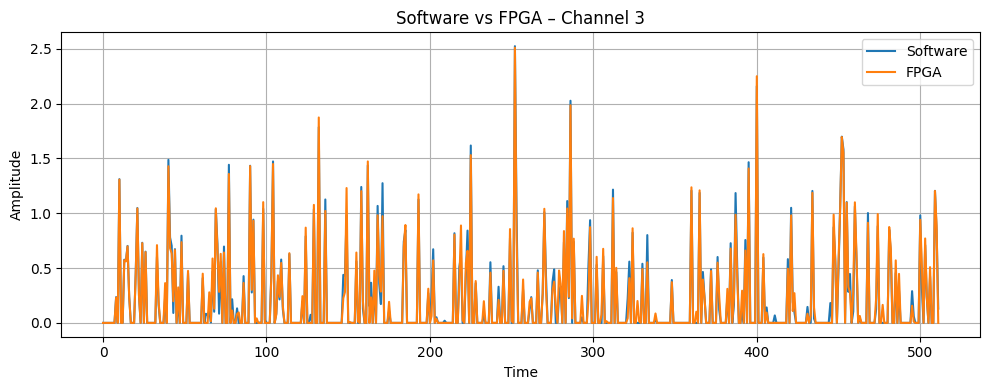

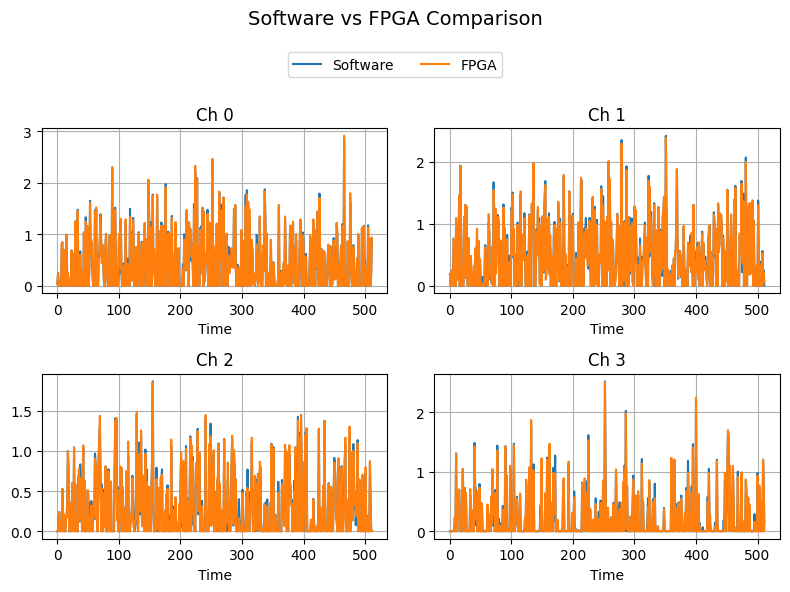

In [267]:
metrics = compare_decoder_outputs(
    decoder_out_original_f,
    decoder_hardware_output_f
)

print("Mean RRMSE:", metrics["rrmse_mean"])
print("Mean Corr:", metrics["corr_mean"])

# Plots
plot_decoder_comparison_single(
    decoder_out_original_f,
    decoder_hardware_output_f,
    channel=3,
    ref_label="Software",
    test_label="FPGA"
)

plot_decoder_comparison(
    decoder_out_original_f,
    decoder_hardware_output_f,
    ref_label="Software",
    test_label="FPGA",
    channels=range(4),
    grid_cols=2
)

### Multiple

In [268]:
decoder_outgroup_path = os.path.join(os.path.abspath("."), "..", "..", "output", "decoder", "seeds")

inputs_decoder_array = inputs_decoder_array
decoder_results = []

for i, item in enumerate(inputs_decoder_array):
    print(f"Processing seed {item["seed"]}")
    # Get Original output
    G.eval()
    decoder_last_input_batched = item["data"].unsqueeze(0)

    with torch.no_grad():
        out_deconv_ref = G.d4.deconv(decoder_last_input_batched)
        out_bn_ref     = G.d4.norm(out_deconv_ref)
        out_d4_ref_original     = G.d4.act(out_bn_ref)

    out_2d_original = out_d4_ref_original.squeeze(0)
    out_f_original = out_2d_original.detach().cpu().numpy().astype(np.float32)

    out_q_original = float_to_q(
        out_f_original,
        frac_bits=14,
        int_bits=10,
        dtype=np.int32
    )

    decoder_out_original_f = q_to_float(out_q_original, FRAC_BITS)

    # Get Hardware outputs
    path = os.path.join(decoder_outgroup_path, f"decoder_output_perchannel_{item["seed"]}.txt")
    decoder_hardware_output = read_decoder_output(path)
    decoder_hardware_output_f = q_to_float(decoder_hardware_output, FRAC_BITS)

    metrics = compare_decoder_outputs(
        decoder_out_original_f,
        decoder_hardware_output_f
    )

    pair_data = {}
    pair_data["seed"] = item["seed"]
    pair_data["original_int"] = out_q_original
    pair_data["hardware_int"] = decoder_hardware_output
    pair_data["original_float"] = decoder_out_original_f
    pair_data["hardware_float"] = decoder_hardware_output_f
    pair_data["metrics"] = metrics

    decoder_results.append(pair_data)

Processing seed 1234
Processing seed 420
Processing seed 67
Processing seed 69
Processing seed 13523100
Processing seed 13223051
Processing seed 13223075
Processing seed 42
Processing seed 21
Processing seed 20


Comparison seed 1234
Mean RRMSE: 0.1017050122609362
Mean Corr: 0.9912437908351421

Comparison seed 420
Mean RRMSE: 0.11090006725862622
Mean Corr: 0.9897758476436138

Comparison seed 67
Mean RRMSE: 0.1122806784696877
Mean Corr: 0.9895372204482555

Comparison seed 69
Mean RRMSE: 0.11837636213749647
Mean Corr: 0.9879459999501705

Comparison seed 13523100
Mean RRMSE: 0.10618196788709611
Mean Corr: 0.9903691373765469

Comparison seed 13223051
Mean RRMSE: 0.1038438850082457
Mean Corr: 0.9909141287207603

Comparison seed 13223075
Mean RRMSE: 0.10584533703513443
Mean Corr: 0.990729782730341

Comparison seed 42
Mean RRMSE: 0.11119543295353651
Mean Corr: 0.9895423203706741

Comparison seed 21
Mean RRMSE: 0.10351108701433986
Mean Corr: 0.9907868579030037

Comparison seed 20
Mean RRMSE: 0.1153344897320494
Mean Corr: 0.9888564273715019

=== Overall Mean Across All Seeds ===
Overall Mean RRMSE: 0.10891743197571487
Overall Mean Corr: 0.989970151335001


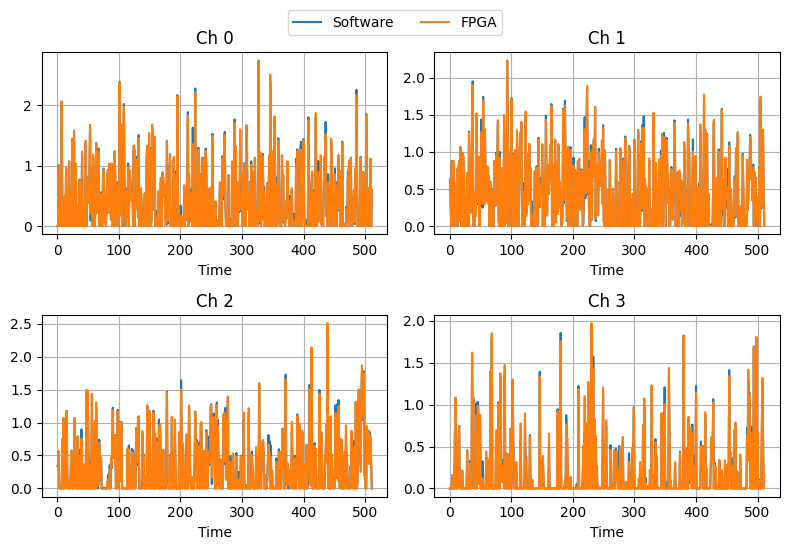

In [269]:
decoder_rrmse = []
decoder_corr = []

for i, data in enumerate(decoder_results):
    print(f"Comparison seed {data["seed"]}")
    print("Mean RRMSE:", data["metrics"]["rrmse_mean"])
    print("Mean Corr:", data["metrics"]["corr_mean"])
    print()

    decoder_rrmse.append(data["metrics"]["rrmse_mean"])
    decoder_corr.append(data["metrics"]["corr_mean"])

decoder_mean_rrmse_all = sum(decoder_rrmse) / len(decoder_rrmse)
decoder_mean_corr_all = sum(decoder_corr) / len(decoder_corr)

print("=== Overall Mean Across All Seeds ===")
print("Overall Mean RRMSE:", decoder_mean_rrmse_all)
print("Overall Mean Corr:", decoder_mean_corr_all)

decoder_first = decoder_results[0]
plot_decoder_comparison(
    decoder_first["original_float"],
    decoder_first["hardware_float"],
    title="",
    ref_label="Software",
    test_label="FPGA",
    channels=range(4),
    grid_cols=2
)

## Out

### Single

In [270]:
def read_out_hex(path, value_per_channel=512):
    channels = []

    with open(path, "r") as f:
        lines = f.readlines()

    values = []
    i = 0
    n = len(lines)

    try:
        while i < n and len(values) < value_per_channel:
            line = lines[i].strip()

            if line != "":
                values.append(str(line))

            i += 1

        if len(values) != value_per_channel:
            raise ValueError(
                f"Expected {value_per_channel} values, got {len(values)}"
            )

        channels.append(values)

    except Exception as e:
        print(f"Error on file line: {i}")
        print(e)

    return channels

def read_out_float(path, value_per_channel=512):
    channels = []

    with open(path, "r") as f:
        lines = f.readlines()

    values = []
    i = 0
    n = len(lines)

    try:
        while i < n and len(values) < value_per_channel:
            line = lines[i].strip()

            if line != "":
                values.append(float(line))

            i += 1

        if len(values) != value_per_channel:
            raise ValueError(
                f"Expected {value_per_channel} values, got {len(values)}"
            )

        # single channel, already float32
        channels.append(np.array(values, dtype=np.float32))

    except Exception as e:
        print(f"Error on file line: {i}")
        print(e)

    return np.stack(channels, axis=0)

def hex_str_to_int(hex_str, bits=16):
    val = int(hex_str, 16)
    if val & (1 << (bits - 1)):
        val -= 1 << bits
    return val

def hex_channels_to_numpy(channels, bits=16, dtype=np.int32):
    np_channels = []

    for ch in channels:
        values = [hex_str_to_int(x, bits) for x in ch]
        np_channels.append(np.array(values, dtype=dtype))

    return np.stack(np_channels, axis=0)


In [271]:
G.eval()
out_input_batched = out_input.unsqueeze(0)

with torch.no_grad():
    out_ref = G.out(out_input_batched)

out_original = out_ref.squeeze(0)
out_f = out_original.detach().cpu().numpy().astype(np.float32)

out_q = float_to_q(
    out_f,
    frac_bits=14,
    int_bits=10,
    dtype=np.int32
)

out_original_f = q_to_float(out_q, FRAC_BITS)

print(out_q)

[[   -83   8912    599    160  12348  10623   -174   7018  -4574 -10601
  -15004 -11151 -13249  -6539  -5609   3734  11844  10814   4270  10800
    8707   5584  11305   4931  -2095    147   6185   2749  -1748  -1334
   -6245  -9254  -3371   -622  -3567  -1294  -3109  -2552    692   4298
    -214   -388  -2069   4732  13777  12179   6050   9633  12004  10365
    5492  11785  10744   9577  10632  -3336  -8653  -2208   5940   8342
    3137   6694  10969   6843   6409   3150  -5158 -11564 -11090  -1585
    7527   7647   6018  11109  10587   5979   1146  -1241   5234  16935
   10014   5784   4876   3349   9139    251  -1513  -5090  -7134 -11190
    -681   4459   3038   4396   7467  12189  10729  -4880  -3487    675
     962    698   1934  -2558   1897   3734  -1286  -4609  -8429   3191
   -3342  -3631  -3778  -1345  -7921  -4876   4543   1175   1057   2977
   -1531  -6596   1026  -9275  -4675   4773   7692   4798  10844   7703
   12081  15340   7999   2678   9201  15687   2739   -652    198

In [272]:
out_single_path = os.path.join(os.path.abspath("."), "..", "..", "output", "out", "out_output_hardware_hex.txt")

out_single_hex = read_out_hex(out_single_path)
out_single_int = hex_channels_to_numpy(out_single_hex, 24)
print(out_single_int)

out_single_f = q_to_float(out_single_int, FRAC_BITS)
print(out_single_f)

[[  -112   8873    550    103  12288  10562   -228   6956  -4629 -10657
  -15054 -11205 -13305  -6594  -5659   3676  11785  10757   4220  10740
    8647   5533  11252   4873  -2149     94   6135   2689  -1815  -1394
   -6303  -9308  -3429   -679  -3622  -1358  -3161  -2614    639   4248
    -274   -446  -2119   4679  13722  12123   5994   9578  11943  10312
    5440  11728  10681   9512  10580  -3394  -8700  -2265   5884   8289
    3076   6644  10910   6787   6349   3094  -5213 -11616 -11139  -1642
    7468   7585   5961  11053  10528   5930   1090  -1299   5169  16875
    9954   5732   4824   3293   9082    196  -1564  -5151  -7192 -11252
    -728   4404   2986   4337   7410  12130  10676  -4938  -3542    619
     909    635   1882  -2615   1840   3678  -1350  -4663  -8485   3133
   -3396  -3685  -3833  -1394  -7983  -4925   4491   1118   1004   2919
   -1594  -6648    970  -9331  -4728   4712   7637   4757  10794   7649
   12020  15288   7935   2632   9156  15635   2681   -705    143

Mean RRMSE: 0.007512426469475031
Mean Corr: 0.9999997019767761


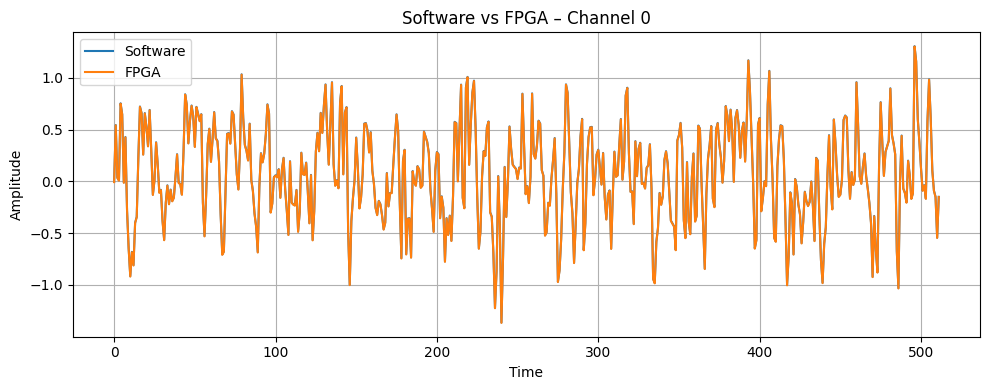

In [273]:
out_manual_metrics = compare_decoder_outputs(
    out_original_f,
    out_single_f
)

print("Mean RRMSE:", out_manual_metrics["rrmse_mean"])
print("Mean Corr:", out_manual_metrics["corr_mean"])

plot_decoder_comparison_single(
    out_original_f,
    out_single_f,
    channel=0,
    ref_label="Software",
    test_label="FPGA"
)

### Multiple

In [274]:
decoder_outgroup_path = os.path.join(os.path.abspath("."), "..", "..", "output", "out", "seeds")

inputs_decoder_array = inputs_decoder_array
out_results = []

for i, item in enumerate(inputs_decoder_array):
    print(f"Processing seed {item["seed"]}")
    # Get Original output
    G.eval()
    out_input_batched = item["data"].unsqueeze(0)

    with torch.no_grad():
        out_deconv_ref = G.d4.deconv(out_input_batched)
        out_bn_ref     = G.d4.norm(out_deconv_ref)
        out_d4_ref_original     = G.d4.act(out_bn_ref)
        out_ref = G.out(out_d4_ref_original)

    out_2d_original = out_ref.squeeze(0)
    out_f_original = out_2d_original.detach().cpu().numpy().astype(np.float32)

    out_q_original = float_to_q(
        out_f_original,
        frac_bits=14,
        int_bits=10,
        dtype=np.int32
    )

    out_out_original_f = q_to_float(out_q_original, FRAC_BITS)

    # Get Hardware outputs
    path = os.path.join(decoder_outgroup_path, f"out_output_sample_{item["seed"]}_hex.txt")
    out_hardware_output = read_out_hex(path)
    out_hardware_output_q = hex_channels_to_numpy(out_hardware_output, 24)
    out_hardware_output_f = q_to_float(out_hardware_output_q, FRAC_BITS)

    metrics = compare_decoder_outputs(
        out_out_original_f,
        out_hardware_output_f
    )

    if item["seed"] == 1234:
        print(out_q_original)
        print(out_hardware_output_q)

    pair_data = {}
    pair_data["seed"] = item["seed"]
    pair_data["original_int"] = out_q_original
    pair_data["hardware_int"] = decoder_hardware_output
    pair_data["original_float"] = decoder_out_original_f
    pair_data["hardware_float"] = decoder_hardware_output_f
    pair_data["metrics"] = metrics

    out_results.append(pair_data)

Processing seed 1234
[[  -261  -1260   4217   6894   6620   4620   2420   3778   5735   3527
   -1810  -1912    524   -993  -3350   -996    719   -176   -683  -1347
    -297  -3223  -8180  -4915  -1802  -3747  -8084  -3602    607  -2638
   -1918    112    138   -704  -5531  -8508  -4745  -1112  -2021  -4125
   -3761   -970  -2183  -4053  -6266  -6382  -5860  -6310  -9131  -8459
   -9409 -14756 -12053  -1705   -791   1383    920  -4141  -2472   -544
    -175  -2803  -3413  -1392  -3447  -7146  -4407    448  -1209  -3638
   -2346  -1097    -73   3565   2440   -862    -26   -195  -2194  -3904
   -5340  -4455   -683  -1564  -4377  -1350  -2387  -3946  -5202  -7209
   -6745  -8464  -5954  -1461   3115  -1254  -5435  -3187   1652  -4113
  -11157 -14436  -8630  -6753  -7933  -3665   -645  -1471  -3697  -2276
    -900     86   3966   5043   2567    242  -2308  -6439  -5582  -1563
    2824   3922  -3469  -5348  -3400  -4301  -6446  -6967  -5762  -4117
    -640  -2745  -3631  -3592  -3094   4035

Comparison seed 1234
Mean RRMSE: 0.07733847200870514
Mean Corr: 0.9964980483055115

Comparison seed 420
Mean RRMSE: 0.08630745112895966
Mean Corr: 0.9955890774726868

Comparison seed 67
Mean RRMSE: 0.07601248472929001
Mean Corr: 0.9961215257644653

Comparison seed 69
Mean RRMSE: 0.09726187586784363
Mean Corr: 0.9947777986526489

Comparison seed 13523100
Mean RRMSE: 0.08543553203344345
Mean Corr: 0.9960293173789978

Comparison seed 13223051
Mean RRMSE: 0.08354349434375763
Mean Corr: 0.9960402250289917

Comparison seed 13223075
Mean RRMSE: 0.08245649933815002
Mean Corr: 0.9963541626930237

Comparison seed 42
Mean RRMSE: 0.08728310465812683
Mean Corr: 0.9956431984901428

Comparison seed 21
Mean RRMSE: 0.0825340673327446
Mean Corr: 0.9962037801742554

Comparison seed 20
Mean RRMSE: 0.08617062866687775
Mean Corr: 0.9952858686447144

=== Overall Mean Across All Seeds ===
Overall Mean RRMSE: 0.08443436101078987
Overall Mean Corr: 0.9958543002605438


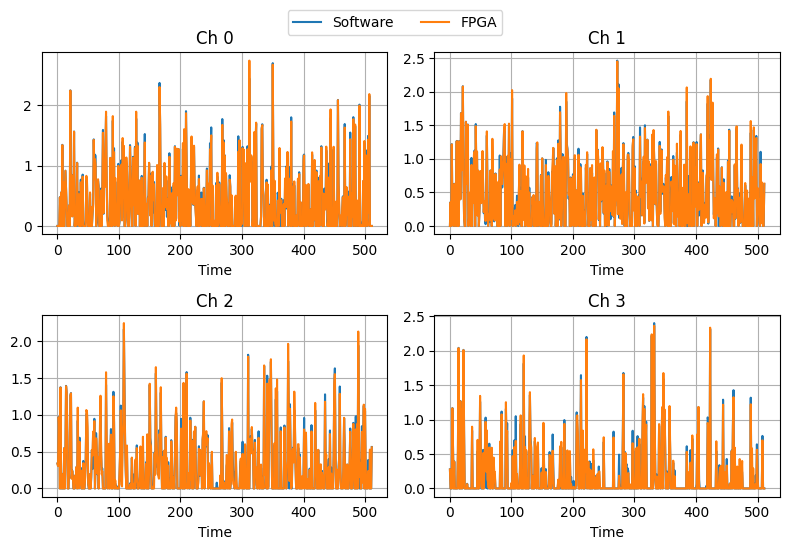

In [276]:
out_rrmse = []
out_corr = []

for i, data in enumerate(out_results):
    print(f"Comparison seed {data["seed"]}")
    print("Mean RRMSE:", data["metrics"]["rrmse_mean"])
    print("Mean Corr:", data["metrics"]["corr_mean"])
    print()

    out_rrmse.append(data["metrics"]["rrmse_mean"])
    out_corr.append(data["metrics"]["corr_mean"])

out_mean_rrmse_all = sum(out_rrmse) / len(out_rrmse)
out_mean_corr_all = sum(out_corr) / len(out_corr)

print("=== Overall Mean Across All Seeds ===")
print("Overall Mean RRMSE:", out_mean_rrmse_all)
print("Overall Mean Corr:", out_mean_corr_all)

out_first = out_results[0]
plot_decoder_comparison(
    out_first["original_float"],
    out_first["hardware_float"],
    title="",
    ref_label="Software",
    test_label="FPGA",
    channels=range(4),
    grid_cols=2
)